In [1]:
# !pip install transformers==3.0.2

In [2]:
# Importing libraries
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
import copy
import os
import logging
logging.basicConfig(level=logging.ERROR)

In [4]:
# Setting up GPU
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
# from google.colab import files
# uploaded = files.upload()

In [6]:
# import the dataset
df = pd.read_csv('KorCCVi_v2.csv').sample(frac=1.0)
df.sample(n=5)

,id,transcript,confidence,label
2071,2071,내는 초등학교 때 오형이어서 막 에이형이나 에이비형인 애들이 막 물 한 입 달라 그...,NaN,0
1878,1878,저는 학교 다닐 때 급식이 정말 맛이 없었거든요. 저희 학교 급식이 너무 맛이 없어...,NaN,0
615,615,최근에 다녀온 여행지 있으십니까? 저는 요기가 고향이 아니라 대구가 고향이기 때문에...,NaN,0
510,510,어~ 저는 지금 7년 동안 연애를 하고 있는 중인데 어~ 혹시 저처럼 길게 연애를 ...,NaN,0
743,743,음~ 여행 저 좋아해요. 아 엄마가 어릴 때부터 엄마가 어릴 때부터 많이 여행을 데...,NaN,0


In [7]:
df = df.drop(['id', 'confidence'], axis=1, inplace=False)
first_column = df.pop('label')
df.insert(0, 'label', first_column)
df.rename(columns = {'label':'Label', 'transcript':'Text'}, inplace = True)

In [8]:
df.sample(n=5)

,Label,Text
2812,1,"10월 달부터 현재까지, 지금까지 수천 만 원의 불법 자금이 돈세탁이 되서 해외로 ..."
2788,1,많은 사람이 시냐고이 사람은 저 모르신다는 왜냐하면 저희가 이마트 지역에서 동영상 ...
1532,0,부모님께서는 님의 그 성향 자체가 외향적이라고 생각하나요 아니면 내향적이라고 생각...
1738,0,너 요즘에 좋아하는 아이돌 있어? 있지. 너 엔시티 알지. 엔시티가 이제 작년 학 ...
1813,0,살아 있다 봤어? 얼마 전에 봤는데 어~ 결말이 조금 많이 별로였던 거 같아. 너무...


# Partitioning

## IID

In [9]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

## Non-IID

In [10]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.get_labels()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict

# MAIN

## MODELS

### KoBERT

In [11]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

/bin/bash: /home/mbmk92/anaconda3/envs/dltest/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-b8m13qm_
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-b8m13qm_
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 4.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 MB 4.6 MB/s eta 0:00:0000:0100:01
INFO: pip is looking at multiple versions of kobert to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the

### Roberta

In [12]:
#Base Roberta model
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [13]:
model = RobertaClass()
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [14]:
#Initialization
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 2
#EPOCHS = 10
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [15]:
class TweetData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Text
        self.targets = self.data.Label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def get_labels(self):
      l = []
      for i in range(len(self.data)):
        # text = str(self.text[i])
        # text = " ".join(text.split())

        # inputs = self.tokenizer.encode_plus(
        #     text,
        #     None,
        #     add_special_tokens=True,
        #     max_length=self.max_len,
        #     pad_to_max_length=True,
        #     return_token_type_ids=True
        # )

        l.append(self.targets[i])

      return l     


    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [16]:
class CustomDataset(Dataset):
  def __init__(self, dataset, tokenizer, max_len, idxs):
      self.data = dataset
      self.idxs = list(idxs)
      self.text = dataset.Text
      self.tokenizer = tokenizer
      self.max_len = max_len
      self.targets = self.data.Label
      
  # def __init__(self, dataset, idxs):
  #     self.dataset = dataset
  #     self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, index):
      text = str(self.text[index])
      text = " ".join(text.split())

      inputs = self.tokenizer.encode_plus(
          text,
          None,
          add_special_tokens=True,
          max_length=self.max_len,
          pad_to_max_length=True,
          return_token_type_ids=True
      )
      ids = inputs['input_ids']
      mask = inputs['attention_mask']
      token_type_ids = inputs["token_type_ids"]


      return {
          'ids': torch.tensor(ids, dtype=torch.long),
          'mask': torch.tensor(mask, dtype=torch.long),
          'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
          'targets': torch.tensor(self.targets[index], dtype=torch.float)
      }

class ClientUpdate(object):
  def __init__(self, dataset, model, tokenizer, loss_function, optimizer, idxs, epochs, MAX_LEN=256):
    self.train_loader = DataLoader(CustomDataset(dataset, tokenizer, MAX_LEN, idxs), batch_size=8, shuffle=True)
    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.epochs = epochs

  # Function to calcuate the accuracy of the model

  def calcuate_accu(self, big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

  def train(self):

    epochloss, epochacc = [], []
    
    for epoch in range(1, self.epochs+1):
      tr_loss = 0
      n_correct = 0
      nb_tr_steps = 0
      nb_tr_examples = 0
      model.train()

      for _,data in enumerate(self.train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = self.model(ids, mask, token_type_ids)
        loss = self.loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += self.calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        self.optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        self.optimizer.step()

      print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
      epoch_loss = tr_loss/nb_tr_steps
      epoch_accu = (n_correct*100)/nb_tr_examples
      print(f"Training Loss Epoch: {epoch_loss}")
      print(f"Training Accuracy Epoch: {epoch_accu}")
      print("-------------------------------")
      epochloss.append(epoch_loss)
      epochacc.append(epoch_accu)

    return model.state_dict(), epochacc[-1], epochloss[-1]

In [17]:
def training(model, rounds, ds, data_dict, loss_function, lr, C, K, E,plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss,train_acc = [], []

  optimizer = torch.optim.Adam(params = model.parameters(), lr=lr)
  
  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss,local_acc = [], [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, model=model, tokenizer=tokenizer, loss_function=loss_function, \
                                  optimizer=optimizer, epochs=E, idxs=data_dict[k])
      weights, acc, loss = local_update.train()

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      local_acc.append(copy.deepcopy(acc))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    acc_avg = sum(local_acc) / len(local_acc)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    print('Round: {}... \tAverage Accuracy: {}'.format(curr_round, round(acc_avg, 3)))
    train_loss.append(loss_avg)
    train_acc.append(acc_avg)

  end = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  # y_axis = np.array(train_loss)
  # ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  # ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
  #      title="Training Loss")
  
  y_axis = np.array(train_acc)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Accuracy',
       title="Training Accuracy vs. Global rounds")
  ax.grid()
  #fig.savefig(plt_title+'.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model,train_acc

In [18]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = TweetData(train_dataset, tokenizer, MAX_LEN)
testing_set = TweetData(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (2927, 2)
TRAIN Dataset: (2342, 2)
TEST Dataset: (585, 2)


In [19]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

### iid training

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 1.1750428676605225
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 1: 67.94871794871794
Training Loss Epoch: 0.7852037012577057
Training Accuracy Epoch: 67.94871794871794
-------------------------------
Training Loss per 5000 steps: 0.5979601740837097
Training Accuracy per 5000 steps: 75.0
The Total Accuracy for Epoch 2: 76.06837606837607
Training Loss Epoch: 0.5954968720674515
Training Accuracy Epoch: 76.06837606837607
-------------------------------
Training Loss per 5000 steps: 0.6749432682991028
Training Accuracy per 5000 steps: 62.5
The Total Accuracy for Epoch 3: 76.06837606837607
Training Loss Epoch: 0.5660668214162191
Training Accuracy Epoch: 76.06837606837607
-------------------------------
Training Loss per 5000 steps: 0.24870336055755615
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 76.06837606837607
Training Loss Epoch: 0.5979468713204066
Training Accuracy Epoch: 76.06837606837607
-------------------

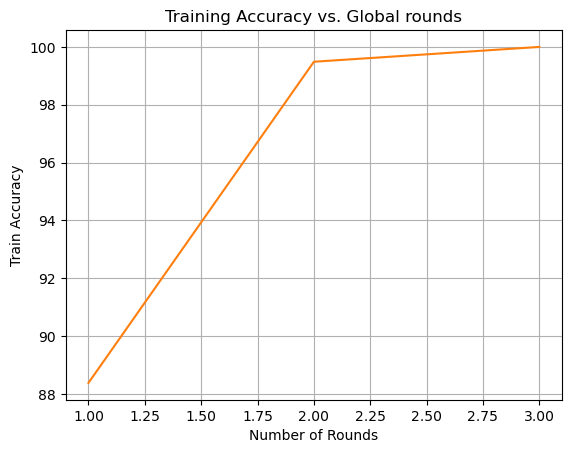

In [20]:
# number of training rounds
rounds = 3
# client fraction
C = 0.5
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 3
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = iid_partition(training_set, 10)
d={}

loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

roberta_iid_trained,train_acc = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [32]:
def calcuate_accuracy(big_idx, targets):
  n_correct = (big_idx==targets).sum().item()
  return n_correct

In [33]:
#Testing the trained model

def valid(model, testing_loader, loss_function):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [34]:
import pickle
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(roberta_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)

d['train_acc'] = train_acc
d['test_acc'] = acc


# with open(f'/content/drive/My Drive/RoBERTa/Sexual_Harassment/FLRoBERTa_Harassment_eps0_5.pkl', 'wb') as file:
#   pickle.dump(d, file)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch


1it [00:00,  2.70it/s]

Validation Loss per 100 steps: 0.0003836342948488891
Validation Accuracy per 100 steps: 100.0


293it [01:19,  3.69it/s]

Validation Loss Epoch: 0.38199475074460876
Validation Accuracy Epoch: 94.01709401709402
Accuracy on test data = 94.02%


Training Loss per 5000 steps: 5.125979896547506e-06
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 100.0
Training Loss Epoch: 5.35690192009497e-06
Training Accuracy Epoch: 100.0
-------------------------------
Training Loss per 5000 steps: 4.827954398933798e-06
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 2: 98.2905982905983
Training Loss Epoch: 0.05865370088530616
Training Accuracy Epoch: 98.2905982905983
-------------------------------
Training Loss per 5000 steps: 2.3990833142306656e-06
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 3: 99.14529914529915
Training Loss Epoch: 0.06294246488326204
Training Accuracy Epoch: 99.14529914529915
-------------------------------
Training Loss per 5000 steps: 0.0011165939504280686
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 99.14529914529915
Training Loss Epoch: 0.05480180882305679
Training Accuracy Epoch: 99.14529914529915
------------------------

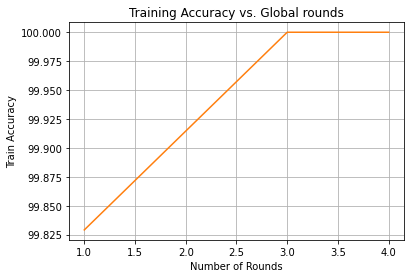

In [40]:
# number of training rounds
rounds = 4
# client fraction
C = 0.5
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 3
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = iid_partition(training_set, 10)
d={}

loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

roberta_iid_trained,train_acc = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [44]:
import pickle
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(roberta_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)

d['train_acc'] = train_acc
d['test_acc'] = acc


# with open(f'/content/drive/My Drive/RoBERTa/Sexual_Harassment/FLRoBERTa_Harassment_eps0_5.pkl', 'wb') as file:
#   pickle.dump(d, file)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch


1it [00:00,  4.78it/s]

Validation Loss per 100 steps: 2.9802242806908907e-06
Validation Accuracy per 100 steps: 100.0


293it [01:17,  3.77it/s]

Validation Loss Epoch: 0.5011329045080669
Validation Accuracy Epoch: 94.1880341880342
Accuracy on test data = 94.19%


Training Loss per 5000 steps: 1.0519900570216123e-05
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 100.0
Training Loss Epoch: 1.7076598870365463e-06
Training Accuracy Epoch: 100.0
-------------------------------
Training Loss per 5000 steps: 5.51342679955269e-07
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 2: 100.0
Training Loss Epoch: 6.704471374045321e-06
Training Accuracy Epoch: 100.0
-------------------------------
Training Loss per 5000 steps: 8.493655059282901e-07
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 3: 98.2905982905983
Training Loss Epoch: 0.18959401705192866
Training Accuracy Epoch: 98.2905982905983
-------------------------------
Training Loss per 5000 steps: 2.071252538371482e-06
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 100.0
Training Loss Epoch: 2.694594099494907e-06
Training Accuracy Epoch: 100.0
-------------------------------
Training Loss per 5000 steps: 3.099

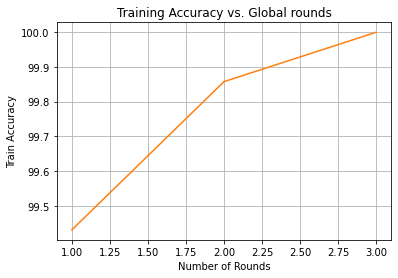

In [41]:
# number of training rounds
rounds = 3
# client fraction
C = 0.3
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 3
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = iid_partition(training_set, 10)
d={}

loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

roberta_iid_trained,train_acc = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [45]:
import pickle
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(roberta_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)

d['train_acc'] = train_acc
d['test_acc'] = acc


# with open(f'/content/drive/My Drive/RoBERTa/Sexual_Harassment/FLRoBERTa_Harassment_eps0_5.pkl', 'wb') as file:
#   pickle.dump(d, file)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch


1it [00:00,  3.22it/s]

Validation Loss per 100 steps: 1.1563171028683428e-05
Validation Accuracy per 100 steps: 100.0


293it [01:17,  3.76it/s]

Validation Loss Epoch: 0.501134860385171
Validation Accuracy Epoch: 94.1880341880342
Accuracy on test data = 94.19%


### non-iid training

{0: array([1919, 1917, 1916, 1915, 1914, 1913, 1912, 1911, 1910, 1909,  501,
       1676, 1677, 1680, 1684, 1664, 1685,  492, 1694, 1695,  120,  727,
        726,  117,  748,  749,  112,  768,  767,  766,  489,  488,  487,
        215,  216,  485,  484,  505,  578,  206, 1652, 1586, 1647, 1644,
       1642, 1641, 1640, 1639, 1638, 1637,  148,  663,  662,  661,  660,
        659,  658,  657,  149,  483, 1543, 1581, 1579, 1578, 1577, 1576,
       1575, 1574, 1572, 1570, 1121, 1120, 1119, 1117, 1116, 1113, 1112,
       1111, 1110, 1109, 1930, 1939, 1943, 1944, 1945, 1946, 1947, 1949,
       1952,  296]), 1: array([ 312,  311,  281,  310,  309,  307,  306,  305,  304,  303,  302,
        301,  300,  284,  285,  287,  299,  298,  297,  289,  601,  605,
        643, 1487,  639, 1492, 1493, 1501,  629, 1506, 1272,  801, 1275,
       1300,  799,  793, 1284, 1285, 1289, 1291,   15,  975,   16,  973,
         17,   18,   19,  982,   20,  968, 1556, 1555, 1553, 1550, 1549,
       1548, 1546, 1545

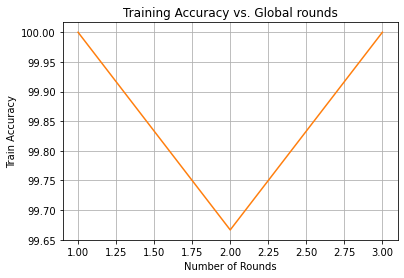

In [35]:
# number of training rounds
rounds = 3
# client fraction
C = 0.3
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 1
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
# data_dict = non_iid_partition(training_set, 10, 240, 10, 10)
data_dict = non_iid_partition(training_set, K, 240, 10, 10)

print(data_dict)
d={}
#iid_partition(training_set, 10)

loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

roberta_non_iid_trained,train_acc = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [36]:
import pickle
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(roberta_non_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)


d['train_acc'] = train_acc
d['test_acc'] = acc


# with open(f'/content/drive/My Drive/RoBERTa/Sexual_Harassment/FLRoBERTa_Harassment_eps0_5_noniid.pkl', 'wb') as file:
#   pickle.dump(d, file)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch


2it [00:00,  3.41it/s]

Validation Loss per 100 steps: 0.23380059003829956
Validation Accuracy per 100 steps: 100.0


293it [01:17,  3.77it/s]

Validation Loss Epoch: 0.595097715085845
Validation Accuracy Epoch: 92.64957264957265
Accuracy on test data = 92.65%


{0: array([2308, 2323, 2183, 2267, 2265, 2224, 2223, 2217, 2216, 2215, 1272,
        801, 1275, 1300,  799,  793, 1284, 1285, 1289, 1291, 1929, 1966,
       1967, 1968, 1970, 2012, 2011, 2009, 2008, 2007,  693,  692,  691,
        137,  689,  688,  138,  687,  139,  685,  865,  864,  863,  862,
         64,  861,  883,  886,   47,  908,  141,  670,  669,  668,  143,
        666,  144,  145,  146,  664,  772, 2277, 1986,   79, 1984, 2150,
       1983, 2170, 2320, 2068,  264,  357,  356,  265,  354,  353,  352,
        266,  267,  349,  308, 1850, 1908, 1901, 1857,  359, 1863, 1864,
        355,  351, 1871, 1870, 1869, 1868, 1867, 1866, 1865, 1862, 1861,
       1860]), 1: array([1039, 1038, 1037, 1036, 1035, 1034, 1033, 1032, 1031, 1029, 1907,
       1906, 1881, 1905, 1903, 1900, 1897, 1894, 1893, 1892, 1008,  555,
        554,  553,  188,  189,  190,  551,  550,  549, 1387, 1385, 1383,
       1400, 1341, 1502, 1504, 1624, 1623, 1622,  508,  531,  197,  528,
        527,  526,  525,  524

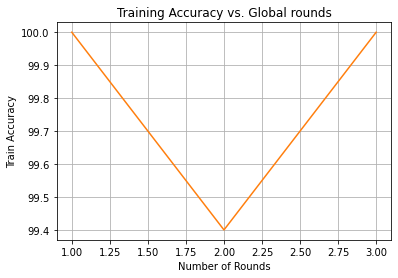

In [38]:
# number of training rounds
rounds = 3
# client fraction
C = 0.5
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 1
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
# data_dict = non_iid_partition(training_set, 10, 240, 10, 10)
data_dict = non_iid_partition(training_set, K, 240, 10, 10)

print(data_dict)
d={}
#iid_partition(training_set, 10)

loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

roberta_non_iid_trained,train_acc = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [42]:
import pickle
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(roberta_non_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)


d['train_acc'] = train_acc
d['test_acc'] = acc


# with open(f'/content/drive/My Drive/RoBERTa/Sexual_Harassment/FLRoBERTa_Harassment_eps0_5_noniid.pkl', 'wb') as file:
#   pickle.dump(d, file)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch


1it [00:00,  2.75it/s]

Validation Loss per 100 steps: 1.2755259376717731e-05
Validation Accuracy per 100 steps: 100.0


293it [01:17,  3.78it/s]

Validation Loss Epoch: 0.5011328947720743
Validation Accuracy Epoch: 94.1880341880342
Accuracy on test data = 94.19%


{0: array([ 530,  522, 1643, 1646, 1648, 1649, 1650, 1651,  517, 1656, 1416,
       1415, 1413, 1411, 1410, 1409, 1406, 1404, 1424, 1401,  498,  497,
        496,  495,  211,  212,  493,  213,  491,  490, 1251, 1249, 1208,
       1206, 1205, 1204, 1203, 1202, 1201, 1200, 1194, 1197, 1207,  878,
       1210,  849, 1214, 1218, 1219, 1220, 2131, 2130, 2129, 2128, 2127,
       2126, 2125, 2124, 2123, 2122, 2175, 2174, 2173, 2171, 2169, 2168,
       2167, 2166, 2165, 2163, 1720,  468, 1724, 1725, 1733,  438,  460,
       1739, 1740,  451, 1129, 1130, 1131, 1132, 1168, 1166, 1165, 1164,
       1163, 1162, 2220, 2282,  222, 2022, 2203,  245, 2020, 2221,  173,
       2284]), 1: array([ 626,  604,  624, 1513, 1517, 1518,  618,  611,  608, 1531,  810,
        841,  751,  746,  745,  744,  743,  742,  741,  114,  249,  405,
        404,  403,  402,  401,  250,  400,  399,  251,  252,  397,  396,
        395,  394,  393,  392,  391,  390,  389,  708,  132,  707,  706,
        133,  705,  704,  703

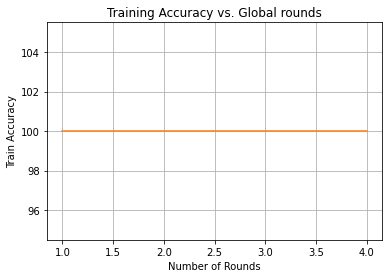

In [39]:
# number of training rounds
rounds = 4
# client fraction
C = 0.3
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 1
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
# data_dict = non_iid_partition(training_set, 10, 240, 10, 10)
data_dict = non_iid_partition(training_set, K, 240, 10, 10)

print(data_dict)
d={}
#iid_partition(training_set, 10)

loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

roberta_non_iid_trained,train_acc = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [43]:
import pickle
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(roberta_non_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)


d['train_acc'] = train_acc
d['test_acc'] = acc


# with open(f'/content/drive/My Drive/RoBERTa/Sexual_Harassment/FLRoBERTa_Harassment_eps0_5_noniid.pkl', 'wb') as file:
#   pickle.dump(d, file)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch


1it [00:00,  4.59it/s]

Validation Loss per 100 steps: 4.64914228359703e-06
Validation Accuracy per 100 steps: 100.0


293it [01:17,  3.78it/s]

Validation Loss Epoch: 0.5011339342230061
Validation Accuracy Epoch: 94.1880341880342
Accuracy on test data = 94.19%
